# CS 189 HW 6: Neural Networks
**Note:** before starting this notebook, please make a copy of it, otherwise your changes will not persist.

This part of the assignment is designed to get you familiar with how engineerings in the real world train neural network systems. It isn't designed to be difficult. In fact, everything you need to complete the assignment is available directly on the pytorch website [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html). This note book will have the following components:

1. Understanding the basics of Pytorch (no deliverables)
2. Training a simple neural network on MNIST (Deliverable = training graphs)
3. Train a model on CIFAR-10 for Kaggle (Deliverable = kaggle submission and explanation of methods)

The last part of this notebook is left open for you to explore as many techniques as you want to do as well as possible on the dataset.

You will also get practice being an ML engineer by reading documentation and using it to implement models. The first section of this notebook will cover an outline of what you need to know -- we are confident that you can find the rest on your own.

Note that like all other assignments, you are free to use this notebook or not. You just need to complete the deliverables and turn in your code. If you want to run everything outside of the notebook, make sure to appropriately install pytorch to download the datasets and copy out the code for kaggle submission. If you don't want to use pytorch and instead want to use Tensorflow, feel free, but you may still need to install pytorch to download the datasets.


In [1]:
# Imports for pytorch
import numpy as np
import torch
import torchvision
from torch import nn
import torch.optim as optim
import matplotlib
from matplotlib import pyplot as plt
import tqdm

In [7]:
np.random.seed(189)
A = np.random.rand(5, 5)
trace_einsum = np.einsum('ii', A)
trace = np.trace(A)
diff = trace_einsum - trace
norm_diff = np.linalg.norm(diff)
norm_diff

0.0

In [13]:
np.random.seed(189)
A = np.random.rand(5, 5)
b = np.random.rand(5)
mul_einsum = np.einsum('ij,j->i', A, b)
mul = np.matmul(A, b)
diff = mul_einsum - mul
norm_diff = np.linalg.norm(diff)
norm_diff

4.002966042486721e-16

In [19]:
np.random.seed(189)
a = np.random.rand(5)
b = np.random.rand(5)
mul_einsum = np.einsum('i,j->ij', a, b)
mul = np.outer(a, b)
diff = mul_einsum - mul
norm_diff = np.linalg.norm(diff)
norm_diff

0.0

# 1. Understanding Pytorch

Pytorch is based on the "autograd" paradigm. Essentially, you perform operations on multi-dimensional arrays like in numpy, except pytorch will automatically handle gradient tracking. In this section you will understand how to use pytorch.

This section should help you understand the full pipeline of creating and training a model in pytorch. Feel free to re-use code from this section in the assigned tasks.

Content in this section closely follows this pytorch tutorial: https://pytorch.org/tutorials/beginner/basics/intro.html

## Tensors

Tensors can be created from numpy data or by using pytorch directly.

In [2]:
data = [[1, 2],[3, 4]]
x_data = torch.tensor(data)

np_array = np.array(data)
x_np = torch.from_numpy(np_array)

shape = (2,3)
rand_tensor = torch.rand(shape)
np_rand_array = rand_tensor.numpy()

print(f"Tensor from np: \n {x_np} \n")
print(f"Rand Tensor: \n {rand_tensor} \n")
print(f"Rand Numpy Array: \n {np_rand_array} \n")

Tensor from np: 
 tensor([[1, 2],
        [3, 4]]) 

Rand Tensor: 
 tensor([[0.1883, 0.9370, 0.5869],
        [0.2753, 0.9025, 0.8263]]) 

Rand Numpy Array: 
 [[0.18833774 0.9370196  0.58692616]
 [0.27533793 0.9025497  0.8262805 ]] 



They also support slicing and math operations very similar to numpy. See the examples below:

In [3]:
# Slicing
tensor = torch.ones(4, 4)
print('First row: ',tensor[0])
print('First column: ', tensor[:, 0])

# Matrix Operations
y1 = tensor @ tensor.T
y2 = tensor.matmul(tensor.T)

# Getting a single item
scalar = torch.sum(y1) # sums all elements
item = scalar.item()
print("Sum as a tensor:", scalar, ", Sum as an item:", item)

First row:  tensor([1., 1., 1., 1.])
First column:  tensor([1., 1., 1., 1.])
Sum as a tensor: tensor(64.) , Sum as an item: 64.0


## Autograd
This small section shows you how pytorch computes gradients. When we create tenors, we can set `requires_grad` to be true to indicate that we are using gradients. For most of the work that you actually do, you will use the `nn` package, which automatically sets all parameter tensors to have `requires_grad=True`.

In [4]:
# Below is an example of computing the gradient for a single data point in logistic regression using pytorch's autograd.

x = torch.ones(5)  # input tensor
y = torch.zeros(1) # label
w = torch.randn(5, 1, requires_grad=True)
b = torch.randn(1, requires_grad=True) 
pred = torch.sigmoid(torch.matmul(x, w) + b)
loss = torch.nn.functional.binary_cross_entropy(pred, y)
loss.backward() # Computers gradients
print("W gradient:", w.grad)
print("b gradient:", b.grad)

# when we want to actually take an update step, we can use optimizers:
optimizer = torch.optim.SGD([w, b], lr=0.1)
print("Weight before", w)
optimizer.step() # use the computed gradients to update 
# Print updated weights
print("Updated weight", w)

# Performing operations with gradients enabled is slow...
# You can disable gradient computation using the following enclosure:
with torch.no_grad():
    # Perform operations without gradients
    ...

W gradient: tensor([[0.9590],
        [0.9590],
        [0.9590],
        [0.9590],
        [0.9590]])
b gradient: tensor([0.9590])
Weight before tensor([[ 1.5553],
        [ 1.0357],
        [ 1.0756],
        [-1.0560],
        [ 0.7102]], requires_grad=True)
Updated weight tensor([[ 1.4594],
        [ 0.9398],
        [ 0.9797],
        [-1.1519],
        [ 0.6143]], requires_grad=True)


## Devices
Pytorch supports accelerating computation using GPUs which are available on google colab. To use a GPU on google colab, go to runtime -> change runtime type -> select GPU.

Note that there is some level of strategy for knowing when to use which runtime type. Colab will kick users off of GPU for a certain period of time if you use it too much. Thus, its best to run simple models and prototype to get everything working on CPU, then switch the instance type over to GPU for training runs and parameter tuning.

Its best practice to make sure your code works on any device (GPU or CPU) for pytorch, but note that numpy operations can only run on the CPU. Here is a standard flow for using GPU acceleration:

In [5]:
# Determine the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)
# Next create your tensors
tensor = torch.zeros(4, 4, requires_grad=True)
# Move the tensor to the device you want to use
tensor = tensor.to(device)

# Perform whatever operations you want.... (often this will involve gradients)
# These operations will be accelerated by GPU.
tensor = 10*(tensor + 1)

# bring the tensor back to CPU, first detaching it from any gradient computations
tensor = tensor.detach().cpu()

tensor_np = tensor.numpy() # Convert to numpy if you want to perform numpy operations.

Using device cuda


## The NN Package
Pytorch implements composable blocks in `Module` classes. All layers and modules in pytorch inherit from `nn.Module`. When you make a module you need to implement two functions: `__init__(self, *args, **kwargs)` and `foward(self, *args, **kwargs)`. Modules also have some nice helper functions, namely `parameters` which will recursively return all of the parameters. Here is an example of a logistic regression model:

In [6]:
class Perceptron(nn.Module):
  def __init__(self, in_dim):
    super().__init__()
    self.layer = nn.Linear(in_dim, 1) # This is a linear layer, it computes Xw + b

  def forward(self, x):
    return torch.sigmoid(self.layer(x)).squeeze(-1)

perceptron = Perceptron(10)
perceptron = perceptron.to(device) # Move all the perceptron's tensors to the device
print("Parameters", list(perceptron.parameters()))

Parameters [Parameter containing:
tensor([[ 0.1771,  0.2744, -0.2152, -0.0474,  0.0205, -0.2297,  0.1942,  0.1860,
          0.1505, -0.0423]], device='cuda:0', requires_grad=True), Parameter containing:
tensor([-0.1331], device='cuda:0', requires_grad=True)]


## Datasets

Pytorch has nice interfaces for using datasets. Suppose we create a logistic regression dataset as follows:

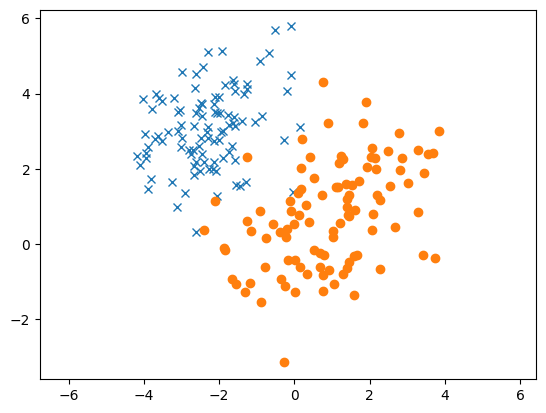

In [7]:
c1_x1, c1_x2 = np.random.multivariate_normal([-2.5,3], [[1, 0.3],[0.3, 1]], 100).T
c2_x1, c2_x2 = np.random.multivariate_normal([1,1], [[2, 1],[1, 2]], 100).T
c1_X = np.vstack((c1_x1, c1_x2)).T
c2_X = np.vstack((c2_x1, c2_x2)).T
train_X = np.concatenate((c1_X, c2_X))
train_y = np.concatenate((np.zeros(100), np.ones(100)))
# Shuffle the data
permutation = np.random.permutation(train_X.shape[0])
train_X = train_X[permutation, :]
train_y = train_y[permutation]
# Plot the data
plt.plot(c1_x1, c1_x2, 'x')
plt.plot(c2_x1, c2_x2, 'o')
plt.axis('equal')
plt.show()

We can then create a pytorch dataset object as follows. Often times, the default pytorch datasets will create these objects for you. Then, we can apply dataloaders to iterate over the dataset in batches.

In [8]:
dataset = torch.utils.data.TensorDataset(torch.from_numpy(train_X), torch.from_numpy(train_y))
# We can create a dataloader that iterates over the dataset in batches.
dataloader = torch.utils.data.DataLoader(dataset, batch_size=10, shuffle=True)
for x, y in dataloader:
    print("Batch x:", x)
    print("Batch y:", y)
    break

# Clean up the dataloader as we make a new one later
del dataloader

Batch x: tensor([[ 1.5697, -1.3532],
        [-1.2845,  1.6578],
        [-3.5167,  3.7931],
        [ 1.0181,  0.3590],
        [ 3.0106,  1.6175],
        [-0.2432, -1.1014],
        [-2.3320,  2.9774],
        [-2.6246,  4.5190],
        [ 2.7942,  1.9647],
        [ 1.4020, -0.6348]], dtype=torch.float64)
Batch y: tensor([1., 0., 0., 1., 1., 1., 0., 0., 1., 1.], dtype=torch.float64)


## Training Loop Example
Here is an example of training a full logistic regression model in pytorch. Note the extensive use of modules -- modules can be used for storing networks, computation steps etc.

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device", device)

epochs = 10
batch_size = 10
learning_rate = 0.01

num_features = dataset[0][0].shape[0]
model = Perceptron(num_features).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
criterion = torch.nn.BCELoss()
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

model.train() # Put model in training mode
for epoch in range(epochs):
    training_losses = []
    for x, y in tqdm.tqdm_notebook(dataloader, unit="batch"):
        x, y = x.float().to(device), y.float().to(device)
        optimizer.zero_grad() # Remove the gradients from the previous step
        pred = model(x)
        loss = criterion(pred, y)
        loss.backward()
        optimizer.step()
        training_losses.append(loss.item())
    print("Finished Epoch", epoch + 1, ", training loss:", np.mean(training_losses))
        
# We can run predictions on the data to determine the final accuracy.
with torch.no_grad():
    model.eval() # Put model in eval mode
    num_correct = 0
    for x, y in dataloader:
        x, y = x.float().to(device), y.float().to(device)
        pred = model(x)
        num_correct += torch.sum(torch.round(pred) == y).item()
    print("Final Accuracy:", num_correct / len(dataset))
    model.train() # Put model back in train mode

Using device cuda


<ipython-input-9-4c28acda599e>:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for x, y in tqdm.tqdm_notebook(dataloader, unit="batch"):


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 1 , training loss: 0.791280648112297


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 2 , training loss: 0.5380097955465317


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 3 , training loss: 0.4262563318014145


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 4 , training loss: 0.37186004519462584


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 5 , training loss: 0.3408441558480263


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 6 , training loss: 0.32059972956776617


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 7 , training loss: 0.3060328170657158


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 8 , training loss: 0.2948684312403202


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 9 , training loss: 0.28594202250242234


  0%|          | 0/20 [00:00<?, ?batch/s]

Finished Epoch 10 , training loss: 0.27854641936719415
Final Accuracy: 0.92


# Task 1: MLP For FashionMNIST
Earlier in this course you trained SVMs and GDA models on MNIST. Now you will train a multi-layer perceptron model on an MNIST-like dataset. Your deliverables are as follows:

1. Code for training an MLP on MNIST (can be in code appendix, tagged in your submission).
2. A plot of the training loss and validation loss for each epoch of training after trainnig for at least 8 epochs.
3. A plot of the training and validation accuracy, showing that it is at least 82% for validation by the end of training. 

Below we will create the training and validation datasets for you, and provide a very basic skeleton of the code. Please leverage the example training loop from above.

Some pytorch components you should definetily use:
1. `nn.Linear`
2. Some activation: `nn.ReLU`, `nn.Tanh`, `nn.Sigmoid`, etc.
3. `nn.CrossEntropyLoss`

Here are challenges you will need to overcome:
1. The data is default configured in image form ie (28 x 28), versus one feature vector. You will need to reshape it somewhere to feed it in as vector to the MLP. There are many ways of doing this.
2. You need to write code for plotting.
3. You need to find appropriate hyper-parameters to achieve good accuracy.

Your underlying model must be fully connected or dense, and may not have convolutions etc., but you can use anything in torch.optim or any layers in torch.nn besides nn.Linear that do not have weights. 

In [10]:
# Creating the datasets
transform = torchvision.transforms.ToTensor() # feel free to modify this as you see fit.

training_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transform,
)

validation_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transform,
)

100%|██████████| 26421880/26421880 [00:01<00:00, 16587146.60it/s]


Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 303022.97it/s]


Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 5594018.65it/s]


Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 17068993.67it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [11]:
# Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [12]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=64,
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=validation_data,
                                           batch_size=64,
                                           shuffle=False)

input_size = 28 * 28  # Size of input feature vector
hidden_size = 128  # Number of hidden units
output_size = 10  # Number of classes
learning_rate = 0.001
num_epochs = 10

# Initialize the model, loss function, and optimizer
model = MLP(input_size, hidden_size, output_size)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [13]:
# Training loop
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0
    train_accuracy = 0.0
    val_accuracy = 0.0

    # Training phase
    model.train()  # Set model to training mode
    for images, labels in train_loader:
        images = images.view(-1, input_size)  # Reshape images to (batch_size, input_size)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()
    

    # Validation phase
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.view(-1, input_size)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            val_accuracy += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for this epoch
    train_loss /= len(train_loader.dataset)
    val_loss /= len(val_loader.dataset)
    train_accuracy /= len(train_loader.dataset)
    val_accuracy /= len(val_loader.dataset)

    # Append to lists for plotting
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy * 100)
    val_accuracies.append(val_accuracy * 100)


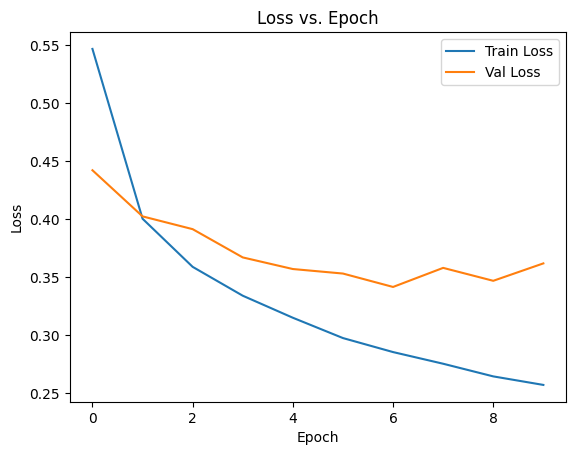

In [14]:
# Plot training losses vs. validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

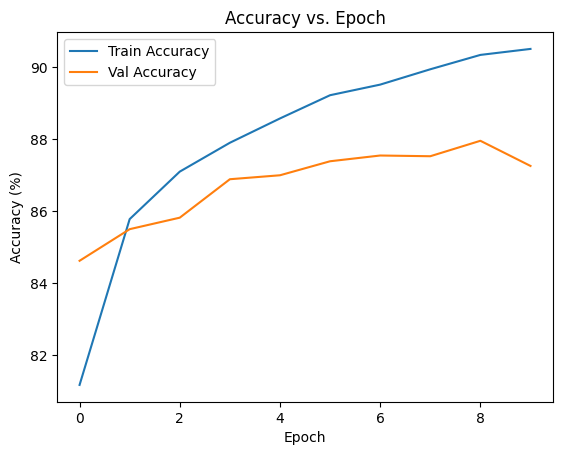

In [16]:
# Plot training accuracies vs. validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy vs. Epoch")
plt.legend()
plt.show()

# Task 2: CNNs for CIFAR-10

In this section, you will create a CNN for the CIFAR dataset, and submit your predictions to Kaggle. It is recommended that you use GPU acceleration for this part.

Here are some of the components you should consider using:
1. `nn.Conv2d`
2. `nn.ReLU`
3. `nn.Linear`
4. `nn.CrossEntropyLoss`
5. `nn.MaxPooling2d` (though many implementations without it exist)

We encourage you to explore different ways of improving your model to get higher accuracy. Here are some suggestions for things to look into:
1. CNN architectures: AlexNet, VGG, ResNets, etc.
2. Different optimizers and their parameters (see torch.optim)
3. Image preprocessing / data augmentation (see torchvision.transforms)
4. Regularization or dropout (see torch.optim and torch.nn respectively)
5. Learning rate scheduling: https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
6. Weight initialization: https://pytorch.org/docs/stable/nn.init.html

Though we encourage you to explore, there are some rules:
1. You are not allowed to install or use packages not included by default in the Colab Environment.
2. You are not allowed to use any pre-defined architectures or feature extractors in your network.
3. You are not allowed to use **any** pretrained weights, ie no transfer learning.
4. You cannot train on the test data.

Otherwise everything is fair game.

Your deliverables are as follows:
1. Submit to Kaggle and include your test accuracy in your report.
2. Provide at least (1) training curve for your model, depicting loss per epoch or step after training for at least 8 epochs.
3. Explain the components of your final model, and how you think your design choices contributed to it's performance.

After you write your code, we have included skeleton code that should be used to submit predictions to Kaggle. **You must follow the instructions below under the submission header**. Note that if you apply any processing or transformations to the data, you will need to do the same to the test data otherwise you will likely achieve very low accuracy. 

It is expected that this task will take a while to train. Our simple solution achieves a training accuracy of 90.2% and a test accuracy of 74.8% after 10 epochs (be careful of overfitting!). This easily beats the best SVM based CIFAR10 model submitted to the HW 1 Kaggle! It is possible to achieve 95% or higher test accuracy on CIFAR 10 with good model design and tuning.

In [17]:
# Creating the datasets, feel free to change this as long as you do the same to the test data.
# You can also modify this to split the data into training and validation.
# See https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split

transform = torchvision.transforms.ToTensor()

training_data = torchvision.datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=transform,
)
# If you make a train-test partition it is up to you.

100%|██████████| 170498071/170498071 [00:02<00:00, 79370719.90it/s]


Extracting data/cifar-10-python.tar.gz to data


# Kaggle Model

In [18]:
# Define device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define data loader
trainloader = torch.utils.data.DataLoader(training_data, batch_size=128, shuffle=True, num_workers=2)

# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 128, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(256 * 8 * 8, 1024)  
        self.fc2 = nn.Linear(1024, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
        

In [25]:
net = Net().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# Train the network
net.train()
num_epochs = 8
training_losses = []
for epoch in range(num_epochs):  
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    training_losses.append(running_loss / len(trainloader))
    print('Epoch [%d/%d], Loss: %.4f, Training Accuracy: %.2f%%' % 
          (epoch+1, num_epochs, running_loss / len(trainloader), 100. * correct / total))

print('Finished training')


Epoch [1/8], Loss: 1.7747, Training Accuracy: 35.15%
Epoch [2/8], Loss: 1.3091, Training Accuracy: 53.22%
Epoch [3/8], Loss: 1.1088, Training Accuracy: 60.73%
Epoch [4/8], Loss: 0.9690, Training Accuracy: 65.97%
Epoch [5/8], Loss: 0.8488, Training Accuracy: 70.31%
Epoch [6/8], Loss: 0.7463, Training Accuracy: 73.96%
Epoch [7/8], Loss: 0.6574, Training Accuracy: 77.21%
Epoch [8/8], Loss: 0.5547, Training Accuracy: 80.90%
Finished training


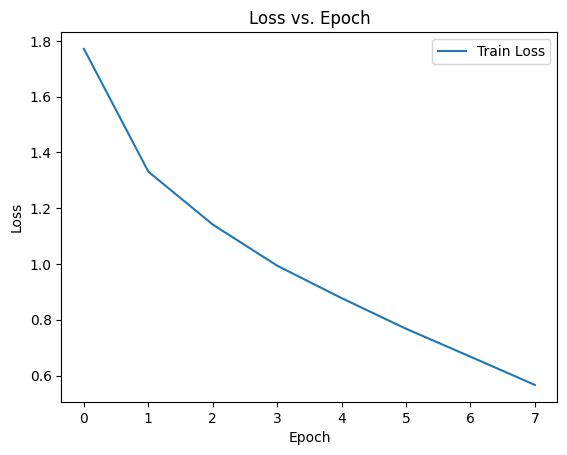

In [20]:
plt.figure()
plt.plot(training_losses, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs. Epoch")
plt.legend()
plt.show()

### Kaggle Submission
The following code is for you to make your submission to kaggle. Here are the steps you must follow:

1. Upload `cifar_test_data.npy` to the colab notebook by going to files on the right hand pane, then hitting "upload". 
2. Run the following cell to generate the dataset object for the test data. Feel free to modify the code to use the same transforms that you use for the training data. By default, this will re-use the `transform` variable.
3. In the second cell, write code to run predictions on the testing dataset and store them into an array called `predictions`.
4. Run the final cell which will convert your predictions array into a CSV for kaggle.
5. Go to the files pane again, and download the file called `submission.csv` by clicking the three dots and then download.


In [21]:
from PIL import Image
import os

class CIFAR10Test(torchvision.datasets.VisionDataset):
    
    def __init__(self, transform=None, target_transform=None):
        super(CIFAR10Test, self).__init__(None, transform=transform,
                                      target_transform=target_transform)
        assert os.path.exists("cifar10_test_data_sp23.npy"), "You must upload the test data to the file system."
        self.data = [np.load("cifar10_test_data_sp23.npy", allow_pickle=False)]

        self.data = np.vstack(self.data).reshape(-1, 3, 32, 32)
        self.data = self.data.transpose((0, 2, 3, 1))  # convert to HWC

    def __getitem__(self, index: int):
        img = self.data[index]
        img = Image.fromarray(img)
        if self.transform is not None:
            img = self.transform(img)
        return img

    def __len__(self) -> int:
        return len(self.data)

# Create the test dataset
testing_data = CIFAR10Test(
    transform=transform, # NOTE: Make sure transform is the same as used in the training dataset.
)

In [22]:
### YOUR CODE HERE ###

# Recommendation: create a `test_dataloader` from torch.utils.data.DataLoader with `shuffle=False` to iterate over the test data in batches.

# Store a numpy vector of the predictions for the test set in the variable `predictions`.

# Define data loader for test dataset
testloader = torch.utils.data.DataLoader(testing_data, batch_size=128, shuffle=False, num_workers=2)
predictions = []

net.eval()
with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        inputs = data.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        predictions.extend(predicted.tolist())

# Convert predictions to NumPy array
predictions = np.array(predictions)


In [23]:
# This code below will generate kaggle_predictions.csv file. Please download it and submit to kaggle.
import pandas as pd

if isinstance(predictions, np.ndarray):
    predictions = predictions.astype(int)
else:
    predictions = np.array(predictions, dtype=int)
assert predictions.shape == (len(testing_data),), "Predictions were not the correct shape"
df = pd.DataFrame({'Category': predictions})
df.index += 1  # Ensures that the index starts at 1. 
df.to_csv('submission.csv', index_label='Id')

# Now download the submission.csv file to submit.

Congrats! You made it to the end.